## 匯入和安裝所需檔案和資料庫


In [1]:
!gdown --id '1IbGifvS34mTmwsfb08f04h9JX1fYMTMV' --output predict.csv
!gdown --id '1Rgn7PWrLL0eph0w7afYW8R4sgDdmlx2d' --output data_train_edge.csv

Downloading...
From: https://drive.google.com/uc?id=1IbGifvS34mTmwsfb08f04h9JX1fYMTMV
To: /content/predict.csv
100% 88.7k/88.7k [00:00<00:00, 32.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Rgn7PWrLL0eph0w7afYW8R4sgDdmlx2d
To: /content/data_train_edge.csv
100% 175k/175k [00:00<00:00, 62.7MB/s]


In [3]:
pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5978 sha256=8781d56322189cbb2624c7076ece1ed48aca0c7b291e2e3a8acdba08d155fc59
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [4]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from node2vec import Node2Vec
from time import time

In [5]:
train = pd.read_csv("data_train_edge.csv")
predict = pd.read_csv("predict.csv")
print("training pairs： %s, predict pairs： %s" % (len(train),len(predict)))

training pairs： 20457, predict pairs： 10231


In [6]:
train.head(5)

,node1,node2
0,287,68
1,63,552
2,189,20
3,380,376
4,370,443


DiGraph with 89 nodes and 50 edges


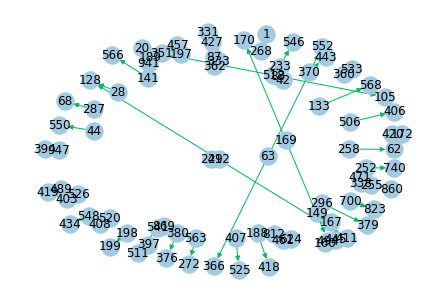

In [18]:
#creating a sample of 50 data points
pd.read_csv('data_train_edge.csv',nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
#reading the edgelist in a variable using networkX
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
#plotting the graph
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

## 原本訓練集的圖

In [19]:
# create graph
G = nx.from_pandas_edgelist(train, "node1", "node2", create_using=nx.DiGraph())

In [20]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes :", str(n))
print("Number of edges :", str(m))

Number of nodes : 979
Number of edges : 20457


In [21]:
print(nx.info(G))

DiGraph with 979 nodes and 20457 edges


#Negative Sampling : 創建與edges相同數量的 Missing edges

In [22]:
#the dict will contain a tuple of 2 nodes as key and the value will be 1 if the nodes are connected
G = nx.from_pandas_edgelist(train, "node1", "node2", create_using=nx.DiGraph())
edges = dict()
for edge in train.values:
    edges[(edge[0], edge[1])] = 1
    
missing_edges = set([])
while (len(missing_edges)< G.number_of_edges()):
    a=random.randint(0, 1004)
    b=random.randint(0, 1004)
    tmp = edges.get((a,b),-1) # if key(a,b) is not in edges(connected nodes) then return -1, otherwise return 1 
    if tmp == -1 and a!=b:
        try:
            # adding points who less likely to be friends
            if nx.shortest_path_length(G,source=a,target=b) > 2: 
                missing_edges.add((a,b))
            else:
                continue  
        except:  
            missing_edges.add((a,b))              
    else:
        continue

In [25]:
print('number of positive samples: %d and negative samples: %d' % (len(edges),len(missing_edges)))

number of positive samples: 20457 and negative samples: 20457


In [26]:
pos = pd.DataFrame(list(edges), columns=['node1', 'node2'])
neg = pd.DataFrame(list(missing_edges), columns=['node1', 'node2'])

In [27]:
train_all = pos.append(neg,ignore_index=True)
y_train_all = np.concatenate((np.ones(len(pos)), np.zeros(len(neg))))

##拆分 Train 和 Test ( 7 : 3 )

In [28]:
# total data 
df_pos = pd.read_csv('data_train_edge.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['node1', 'node2'])
print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])
 
# Spilt data into 70-30 positive/negative links seperatly,we only need "positive training data" for creating graph and features
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.3, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.3, random_state=9)
print('\n')
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
print('\n')
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

Number of nodes in the graph with edges 20457
Number of nodes in the graph without edges 20457


Number of nodes in the train data graph with edges 14319
Number of nodes in the train data graph without edges 14319


Number of nodes in the test data graph with edges 6138
Number of nodes in the test data graph without edges 6138


In [30]:
train_graph=nx.from_pandas_edgelist(X_train_pos, "node1", "node2", create_using=nx.DiGraph())
test_graph=nx.from_pandas_edgelist(X_test_pos, "node1", "node2", create_using=nx.DiGraph())
print(nx.info(train_graph),'\n')
print(nx.info(test_graph),'\n')

# find the unique nodes in the both train and test graphs
train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
trY_teN = len(train_nodes_pos - test_nodes_pos)
teY_trN = len(test_nodes_pos - train_nodes_pos)

print('# of people common in train and test -- ',trY_teY)
print('# of people present in train but not present in test -- ',trY_teN)
print('# of people present in test but not present in train -- ',teY_trN) #比較沒有冷啟動問題
print(' % of people not in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

DiGraph with 941 nodes and 14319 edges 

DiGraph with 881 nodes and 6138 edges 

# of people common in train and test --  843
# of people present in train but not present in test --  98
# of people present in test but not present in train --  38
 % of people not in Train but exist in Test in total Test data are 4.313280363223609 %


In [31]:
# concatenate positive & negative samples
X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg))

In [32]:
print("X_train: %s, X_test: %s " % (len(X_train), len(X_test)))

X_train: 28638, X_test: 12276 


##拆分 Train 和 Validation ( 8 : 2 )


In [33]:
X_train_tra_pos, X_train_val_pos, y_train_tra_pos, y_train_val_pos  = train_test_split(X_train_pos,np.ones(len(X_train_pos)),test_size=0.2, random_state=9)
X_train_tra_neg, X_train_val_neg, y_train_tra_neg, y_train_val_neg  = train_test_split(X_train_neg,np.zeros(len(X_train_neg)),test_size=0.2, random_state=9)

In [34]:
train_tra_graph=nx.from_pandas_edgelist(X_train_tra_pos, "node1", "node2", create_using=nx.DiGraph())
train_val_graph=nx.from_pandas_edgelist(X_train_val_pos, "node1", "node2", create_using=nx.DiGraph())
print(nx.info(train_tra_graph),'\n')
print(nx.info(train_val_graph),'\n')

DiGraph with 917 nodes and 11455 edges 

DiGraph with 778 nodes and 2864 edges 



In [35]:
# concatenate positive & negative samples
X_train_tra = X_train_tra_pos.append(X_train_tra_neg, ignore_index=True)
y_train_tra = np.concatenate((y_train_tra_pos, y_train_tra_neg))
X_train_val = X_train_val_pos.append(X_train_val_neg, ignore_index=True)
y_train_val = np.concatenate((y_train_val_pos, y_train_val_neg))

In [36]:
print("X_train_train: %s, X_train_validation: %s " % (len(X_train_tra), len(X_train_val)))

X_train_train: 22910, X_train_validation: 5728 


## Features Extraction

In [37]:
'''
"successor" of n is a node m such that there exists a directed edge "from n to m" (n->m ,n向外指向的nodes數)
"predecessor" of n is a node m such that there exists a directed edge "from m to n" (m->n ,指向n的nodes數)
此處因是directed graph，定義「被指向者」為朋友，ex：a->b，b為a的朋友
'''
# 1.Jaccard_coefficient
def cal_jaccard_coefficient(a,b,train_graph):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                 (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
        return sim
    except:
        return 0

# 2.Adar Index
def calc_adar_in(a,b,train_graph):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))) #同時被 a、b指向者(common friends)
        if len(n)!=0:
            for i in n:
                a = len(list(train_graph.predecessors(i))) #每一個common friend的朋友數量(指向 i 的數量)
                if a > 1:
                    sum =sum +(1/np.log10(a)) # i 的朋友數越多，權重佔比越小 
                else:
                    continue
            return sum
        else:
            return 0
    except:
        return 0

In [38]:
# 3.Shortest path
def compute_shortest_path_length(a,b,train_graph):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [39]:
# 4.Follow back
def follows_back(a,b,train_graph):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [40]:
print(nx.info(G))

DiGraph with 979 nodes and 20457 edges


In [41]:
print(nx.info(train_graph))

DiGraph with 941 nodes and 14319 edges


In [42]:
print(nx.info(train_tra_graph))

DiGraph with 917 nodes and 11455 edges


In [43]:
# 5.Page rank(count the number and quality of nodes to determine how important the node is)
'''
For the data points which exists in test dataset but not exists in the train dataset will not have pagerank value.
For these data points,just use the mean pagerank as imputation.
'''
def pg_rank(train_graph):
    pr = nx.pagerank(train_graph, alpha=0.85) #dict
    mean_pr = float(sum(pr.values())) / len(pr)
    print("pg rank")
    print('min',pr[min(pr, key=pr.get)])
    print('max',pr[max(pr, key=pr.get)])
    print('mean',mean_pr)
    return pr, mean_pr

In [44]:
# 6.Katz Centrality(measure influence by taking into account the total number of walks between a pair of nodes)
def katz_central(train_graph):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    mean_katz = float(sum(katz.values())) / len(katz)
    print('Katz Centrality')
    print('min',katz[min(katz, key=katz.get)])
    print('max',katz[max(katz, key=katz.get)])
    print('mean',mean_katz)
    return katz, mean_katz

In [45]:
# 7.HITS
'''
HITS identifies good authorities and hubs for a topic by assigning two numbers to a node : an authority and a hub weight. 
Authorities estimate the node value based on the incoming links. 
Hubs estimates the node value based on outgoing links.
'''
def HITS(train_graph):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    mean_hits = float(sum(hits[0].values())) / len(hits[0])
    print('Hyper-link induced topic search (HITS)')
    print('min',hits[0][min(hits[0], key=hits[0].get)])
    print('max',hits[0][max(hits[0], key=hits[0].get)])
    print('mean',mean_hits,'\n')
    return hits, mean_hits

In [46]:
def compute_features_follow(df_final):
    #calculating no of followers followees for node1 and node2
    #calculating intersection of followers and followees for node1 and node2
    num_followers_1=[]
    num_followees_1=[]
    num_followers_2=[]
    num_followees_2=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            n1_p=set(train_graph.predecessors(row['node1']))
            n1_s=set(train_graph.successors(row['node1']))
        except:
            n1_p = set()
            n1_s = set()
        try:
            n2_p =set(train_graph.predecessors(row['node2']))
            n2_s =set(train_graph.successors(row['node2']))
        except:
            n2_p = set()
            n2_s = set()
        num_followers_1.append(len(n1_p))
        num_followees_1.append(len(n1_s))

        num_followers_2.append(len(n2_p))
        num_followees_2.append(len(n2_s))

        inter_followers.append(len(n1_p.intersection(n2_p)))
        inter_followees.append(len(n1_s.intersection(n2_s)))
    
    return num_followers_1, num_followers_2, num_followees_1, num_followees_2, inter_followers, inter_followees

## Node2vec 計算

In [47]:
# Precompute probabilities and generate walks 
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=10)  

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/979 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


In [48]:
def cosin_distance(vector1, vector2):
    dot_product = 0.0
    normA = 0.0
    normB = 0.0
    for a, b in zip(vector1, vector2):
        dot_product += a * b
        normA += a ** 2
        normB += b ** 2
    if normA == 0.0 or normB == 0.0:
        return None
    else:
        return dot_product / ((normA * normB) ** 0.5)

def cos_sim(x_train):
    node_sim = [] 
    for i,j in x_train[['node1','node2']].values:
        try:
            sim = cosin_distance(model.wv.get_vector(str(i)),model.wv.get_vector(str(j)))
        except:
            sim = -1
        node_sim.append(sim)
    
    final_sim = np.round(node_sim,3)
    return final_sim

In [66]:
#將後續的csv直接存進google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## map features to data

In [69]:
def map_features(X_train, train_graph, df_to_write_in, link_y):
    start_time = time()

    X_train['jaccard_coef'] = X_train.apply(lambda row:cal_jaccard_coefficient(row['node1'],row['node2'],train_graph),axis=1)
    X_train['adar_index'] = X_train.apply(lambda row: calc_adar_in(row['node1'],row['node2'],train_graph),axis=1)
    X_train['shortest_path'] = X_train.apply(lambda row: compute_shortest_path_length(row['node1'],row['node2'],train_graph),axis=1)
    X_train['follows_back'] = X_train.apply(lambda row: follows_back(row['node1'],row['node2'],train_graph),axis=1)
    
    pr, mean_pr = pg_rank(train_graph)
    X_train['page_rank_n1'] = X_train.node1.apply(lambda x:pr.get(x,mean_pr))
    X_train['page_rank_n2'] = X_train.node2.apply(lambda x:pr.get(x,mean_pr))

    katz, mean_katz = katz_central(train_graph)
    X_train['katz_n1'] = X_train.node1.apply(lambda x: katz.get(x,mean_katz))
    X_train['katz_n2'] = X_train.node2.apply(lambda x: katz.get(x,mean_katz))

    hits, mean_hits = HITS(train_graph)
    X_train['hubs_n1'] = X_train.node1.apply(lambda x: hits[0].get(x,0))
    X_train['hubs_n2'] = X_train.node2.apply(lambda x: hits[0].get(x,0))
    X_train['authorities_n1'] = X_train.node1.apply(lambda x: hits[1].get(x,0))
    X_train['authorities_n2'] = X_train.node2.apply(lambda x: hits[1].get(x,0))

    X_train['num_followers_node1'], X_train['num_followers_node2'], \
    X_train['num_followees_node1'], X_train['num_followees_node2'], \
    X_train['inter_followers'], X_train['inter_followees']= compute_features_follow(X_train)
    
    X_train['cos_sim'] = cos_sim(X_train)
    
    X_train['link'] = link_y
    print("--- %s seconds ---" % (time() - start_time))
    X_train.to_csv('/content/drive/My Drive/dataset/SNA_HW01/%s.csv'% (df_to_write_in), index=False)
    
    return X_train

In [70]:
x_train_train = map_features(X_train_tra, train_tra_graph, 'X_train_train', y_train_tra)

pg rank
min 0.00023249521851032023
max 0.006145815855933249
mean 0.0010905125408942203
Katz Centrality
min 0.030764084388899843
max 0.04626070636656053
mean 0.032945187738893274
Hyper-link induced topic search (HITS)
min -1.3564662905845446e-21
max 0.010699725544801638
mean 0.0010905125408942201 

--- 15.333518028259277 seconds ---


In [71]:
x_train_valid = map_features(X_train_val, train_tra_graph, 'X_train_valid', y_train_val)

pg rank
min 0.00023249521851032023
max 0.006145815855933249
mean 0.0010905125408942203
Katz Centrality
min 0.030764084388899843
max 0.04626070636656053
mean 0.032945187738893274
Hyper-link induced topic search (HITS)
min -9.203057194443623e-22
max 0.010699725544801638
mean 0.0010905125408942201 

--- 4.057105541229248 seconds ---


In [59]:
x_train_train.head(2)

,node1,node2,jaccard_coef,adar_index,shortest_path,follows_back,page_rank_n1,page_rank_n2,katz_n1,katz_n2,hubs_n1,hubs_n2,authorities_n1,authorities_n2,num_followers_node1,num_followers_node2,num_followees_node1,num_followees_node2,inter_followers,inter_followees,cos_sim,link
0,377,464,0.015873,0.642549,2,0,0.002497,0.001481,0.037040,0.033979,0.002291,0.001809,0.002205,0.001710,44,24,75,16,2,1,0.351,1.0
1,918,974,0.000000,0.000000,3,1,0.000747,0.000491,0.032171,0.031291,0.000229,0.000332,0.000528,0.000206,10,5,7,5,1,2,0.885,1.0


In [72]:
X_train = map_features(X_train, train_graph, 'X_train', y_train)

pg rank
min 0.00021959185555172543
max 0.01735752592679496
mean 0.0010626992561105259
Katz Centrality
min 0.029792118947849715
max 0.048514075530370925
mean 0.03247480243102524
Hyper-link induced topic search (HITS)
min -5.470288554805248e-22
max 0.011597444478093554
mean 0.0010626992561105196 

--- 19.34031867980957 seconds ---


In [62]:
X_train.describe()

,node1,node2,jaccard_coef,adar_index,shortest_path,follows_back,page_rank_n1,page_rank_n2,katz_n1,katz_n2,hubs_n1,hubs_n2,authorities_n1,authorities_n2,num_followers_node1,num_followers_node2,num_followees_node1,num_followees_node2,inter_followers,inter_followees,cos_sim,link
count,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,2.863800e+04,2.863800e+04,2.863800e+04,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,433.875550,433.220372,0.053919,1.974162,1.407780,0.206160,0.001389,0.001398,0.033736,0.033679,1.744591e-03,1.593590e-03,1.553683e-03,1.533863e-03,21.423947,21.109575,23.998324,21.700363,2.882883,2.853865,0.401520,0.500000
std,291.116849,288.482083,0.121212,3.692669,1.650378,0.404554,0.001177,0.001304,0.003804,0.003686,2.225389e-03,2.063364e-03,1.729743e-03,1.696387e-03,21.604225,20.900841,28.251352,25.694544,4.797601,5.196530,0.331722,0.500009
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000219,0.000219,0.029790,0.029790,-7.127490e-22,-7.127490e-22,-2.373625e-20,-2.373625e-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,175.000000,179.000000,0.000000,0.000000,-1.000000,0.000000,0.000607,0.000619,0.030959,0.030998,1.789257e-04,1.590935e-04,2.647257e-04,2.744703e-04,5.000000,5.000000,4.000000,3.000000,0.000000,0.000000,0.286000,0.000000
50%,400.000000,397.000000,0.000000,0.000000,2.000000,0.000000,0.001063,0.001063,0.032526,0.032526,8.688979e-04,7.669190e-04,8.945865e-04,8.976211e-04,16.000000,15.000000,15.000000,14.000000,1.000000,0.000000,0.414000,0.500000
75%,676.000000,668.000000,0.074074,2.951680,3.000000,0.000000,0.001767,0.001733,0.035155,0.035066,2.415448e-03,2.291964e-03,2.315646e-03,2.213054e-03,30.000000,29.000000,33.750000,31.000000,5.000000,4.000000,0.582000,1.000000
max,1004.000000,1004.000000,1.000000,93.290464,6.000000,1.000000,0.017358,0.017358,0.048511,0.048511,1.159626e-02,1.159626e-02,7.640154e-03,7.640154e-03,106.000000,106.000000,181.000000,181.000000,105.000000,123.000000,1.000000,1.000000


In [73]:
X_test = map_features(X_test, train_graph, 'X_test', y_test)

pg rank
min 0.00021959185555172543
max 0.01735752592679496
mean 0.0010626992561105259
Katz Centrality
min 0.029792118947849715
max 0.048514075530370925
mean 0.03247480243102524
Hyper-link induced topic search (HITS)
min -3.9421002705619746e-22
max 0.011597444478093553
mean 0.0010626992561105196 

--- 8.692913293838501 seconds ---


In [74]:
train_all = map_features(train_all, G, 'train_all', y_train_all)

pg rank
min 0.00019951718342611836
max 0.018098765268953827
mean 0.0010214504596527114
Katz Centrality
min 0.027889223556596947
max 0.05790579408362676
mean 0.03168687221694042
Hyper-link induced topic search (HITS)
min -2.460574751624447e-22
max 0.011219818790666733
mean 0.0010214504596527073 

--- 28.948695182800293 seconds ---


In [75]:
predict = map_features(predict, G, 'predict_all', np.zeros(len(predict)))

pg rank
min 0.00019951718342611836
max 0.018098765268953827
mean 0.0010214504596527114
Katz Centrality
min 0.027889223556596947
max 0.05790579408362676
mean 0.03168687221694042
Hyper-link induced topic search (HITS)
min -1.4639585718683437e-22
max 0.011219818790666735
mean 0.0010214504596527073 

--- 7.914595127105713 seconds ---
